# Gaussian Process FEM Method on the 1D Dirichlet Problem

In [1]:
import experiment_utils
from experiment_utils import config

config.experiment_name = "0002_poisson_dirichlet_gp_fem"
config.target = "jmlr"
config.debug_mode = True

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import probnum as pn

import linpde_gp

plt.rcParams.update(config.tueplots_bundle())

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


## Problem Definition

In [3]:
domain = linpde_gp.domains.asdomain([-1.0, 1.0])
alpha = 1.0
rhs = linpde_gp.functions.Piecewise(
    xs=[-1.0, -0.3, 0.1, 1.0],
    fns=[
        linpde_gp.functions.Polynomial([3.0]),
        linpde_gp.functions.Polynomial([0.0]),
        linpde_gp.functions.Polynomial([2.0]),
    ],
)

solution = linpde_gp.problems.pde.Solution_PoissonEquation_IVP_1D_RHSPiecewisePolynomial(
    domain,
    rhs,
    initial_values=[0.5, 3.0],
    alpha=alpha,
)

bvp = linpde_gp.problems.pde.PoissonEquationDirichletProblem(
    domain,
    rhs=rhs,
    alpha=alpha,
    boundary_values=np.asarray((solution(-1.), solution(1.))),
    solution=solution,
)

## Test and Trial Bases

In [4]:
num_finite_elements = 5

basis_grid = np.linspace(*bvp.domain, num_finite_elements + 2)

trial_basis = linpde_gp.functions.bases.UnivariateLinearInterpolationBasis(
    basis_grid,
    zero_boundary=False,
)

test_basis = linpde_gp.functions.bases.UnivariateLinearInterpolationBasis(
    basis_grid,
    zero_boundary=True,
)

trial_proj = trial_basis.l2_projection()
test_proj = test_basis.l2_projection(normalized=False)

## Plotting

In [5]:
%matplotlib inline

import matplotlib.axes
from probnum.typing import ArrayLike

from linpde_gp.typing import RandomProcessLike


plt_grid = bvp.domain.uniform_grid(200)

fig_1_plot_rel_width = 0.45
fig_1_plot_aspect = 10 / 16


def plot_belief(
    ax: matplotlib.axes.Axes,
    *,
    u: pn.randprocs.GaussianProcess,
    projection: linpde_gp.linfunctls.projections.l2.L2Projection_UnivariateLinearInterpolationBasis | None = None,
    conditioned_on: list[str] = [],
    Y_bc_meas: ArrayLike | None = None,
    noise_bc_meas: pn.randvars.Normal | None = None,
    X_u_meas: ArrayLike | None = None,
    Y_u_meas: ArrayLike | None = None,
    noise_u_meas: pn.randvars.Normal | None = None,
    show_projection_basis: linpde_gp.linfunctls.projections.l2.L2Projection_UnivariateLinearInterpolationBasis | None = None,
    solution: RandomProcessLike | None = None,
):
    # True Solution
    if solution is not None:
        solution.plot(
            ax,
            plt_grid,
            color=config.color["sol"],
            label="$u^\star$",
        )

    # Solution Belief
    Pu = u
    label = r"\mathrm{u}"

    if projection is not None:
        Pu = linpde_gp.randprocs.ParametricGaussianProcess(
            weights=projection(u),
            feature_fn=projection.basis,
        )
        label = r"\mathcal{P}[\mathrm{u}]"

    cond_events_str = _build_cond_events_str(conditioned_on)

    if len(cond_events_str) > 0:
        label += fr" \mid {cond_events_str}"

    Pu.plot(
        ax,
        plt_grid,
        num_samples=3,
        rng=np.random.default_rng(24),
        color=config.color["u"],
        label=f"${label}$",
        samples_kwargs={
            "linewidth": plt.rcParams["lines.linewidth"] * 0.75,
        }
    )

    for key in conditioned_on:
        match key:
            case "bc":
                X_bc, _ = linpde_gp.problems.pde.get_1d_dirichlet_boundary_observations(
                    bvp.boundary_conditions
                )
                Y_bc_meas = np.asarray(Y_bc_meas)
                Y_bc_meas_std = np.zeros_like(Y_bc_meas)
                label = r"u^\star(\bm{X}_{\mathrm{BC}})"

                if noise_bc_meas is not None:
                    Y_bc_meas_std = noise_bc_meas.std
                    label += r" + \bm{\mathrm{\epsilon}}_{\mathrm{BC}}"

                ax.errorbar(
                    X_bc,
                    Y_bc_meas,
                    yerr=1.96 * Y_bc_meas_std,
                    fmt="+",
                    capsize=2,
                    color=config.color["bc"],
                    label=f"${label}$",
                )
            case "u_meas":
                X_u_meas = np.asarray(X_u_meas)
                Y_u_meas = np.asarray(Y_u_meas)

                ax.errorbar(
                    X_u_meas,
                    Y_u_meas,
                    yerr=1.96 * noise_u_meas.std,
                    fmt="+",
                    capsize=2,
                    color=config.color["u_meas"],
                    label=r"$u^\star(\bm{X}_{\mathrm{MEAS}}) + \bm{\mathrm{\epsilon}}_{\mathrm{MEAS}}$",
                )

    if show_projection_basis is not None:
        _plot_projection_basis(
            ax,
            u=u,
            projection=show_projection_basis,
            color=config.color["pde"],
            alpha=0.1,
        )

    ax.set_ylim(-0.1, 2.6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"Domain $\mathbb{D}$")
    ax.legend()


def _plot_projection_basis(
    ax: matplotlib.axes.Axes,
    u: pn.randprocs.GaussianProcess,
    projection: linpde_gp.linfunctls.projections.l2.L2Projection_UnivariateLinearInterpolationBasis,
    **plot_kwargs,
):
    Pu = projection(u)

    basis = projection.basis
    coeffs = Pu.mean

    assert not projection.basis.zero_boundary

    ax.plot(
        [basis.x_i[0], basis.x_ip1[0]],
        [coeffs[0], 0.0],
        **plot_kwargs,
    )

    for i in range(1, len(basis) - 1):
        ax.plot(
            [basis.x_im1[i], basis.x_i[i], basis.x_ip1[i]],
            [0.0, coeffs[i], 0.0],
            **plot_kwargs,
        )

    ax.plot(
        [basis.x_im1[-1], basis.x_i[-1]],
        [0.0, coeffs[-1]],
        **plot_kwargs,
    )


def _build_cond_events_str(conditioned_on: list[str]) -> str:
    events = []

    for key in conditioned_on:
        match key:
            case "bc":
                events.append(r"\mathrm{BC}")
            case "pde":
                events.append(r"\mathrm{PDE}")
            case "u_meas":
                events.append(r"\mathrm{MEAS}")
            case _:
                raise ValueError(f"Unknown event '{key}'")

    return ", ".join(events)

## Prior

In [6]:
u_prior = pn.randprocs.GaussianProcess(
    mean=linpde_gp.functions.Constant(
        input_shape=(),
        value=1.3,
    ),
    cov=0.6 ** 2 * pn.randprocs.covfuncs.Matern(
        input_shape=(),
        lengthscales=0.7,
        nu=1.5,
    ),
)

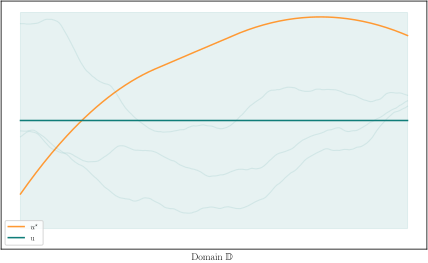

In [7]:
plot_belief(
    plt.gca(),
    u=u_prior,
    solution=bvp.solution,
)

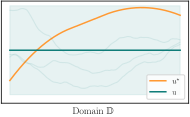

In [8]:
with plt.rc_context(
    config.tueplots_bundle(
        rel_width=fig_1_plot_rel_width,
        height_to_width_ratio=fig_1_plot_aspect,
    )
):
    plot_belief(
        plt.gca(),
        u=u_prior,
        solution=bvp.solution,
    )

    experiment_utils.savefig("00_u_prior_fig_1")

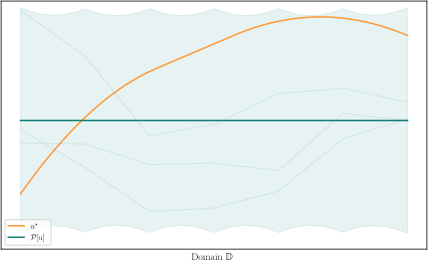

In [9]:
plot_belief(
    plt.gca(),
    u=u_prior,
    projection=trial_proj,
    solution=bvp.solution,
)

# experiment_utils.savefig("00_u_prior_proj")

## Solving the Exact Problem

### Conditioning on the Boundary Conditions

In [10]:
X_bc, Y_bc = linpde_gp.problems.pde.get_1d_dirichlet_boundary_observations(bvp.boundary_conditions)

In [11]:
u_cond_bc = u_prior.condition_on_observations(Y_bc, X=X_bc)

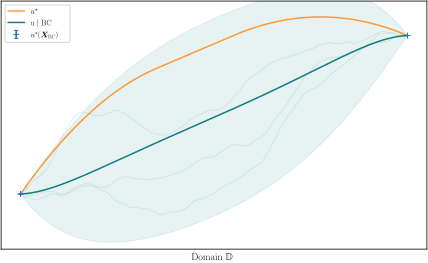

In [12]:
plot_belief(
    plt.gca(),
    u=u_cond_bc,
    conditioned_on=["bc"],
    Y_bc_meas=Y_bc,
    solution=bvp.solution,
)

experiment_utils.savefig("01_00_u_cond_bc")

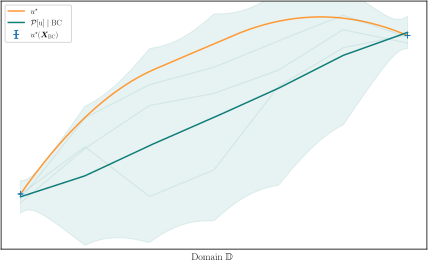

In [13]:
plot_belief(
    plt.gca(),
    u=u_cond_bc,
    projection=trial_proj,
    conditioned_on=["bc"],
    Y_bc_meas=Y_bc,
    solution=bvp.solution,
)

experiment_utils.savefig("01_00_u_cond_bc_proj")

### Conditioning on the PDE

In [14]:
diffop_galerkin = bvp.pde.diffop.weak_form(test_basis)(trial_basis)
rhs_galerkin = test_proj(bvp.pde.rhs)

In [15]:
u_cond_bc_pde = u_cond_bc.condition_on_observations(
    rhs_galerkin,
    L=diffop_galerkin @ trial_proj,
)

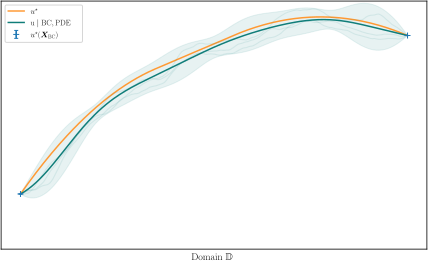

In [16]:
plot_belief(
    plt.gca(),
    u=u_cond_bc_pde,
    conditioned_on=["bc", "pde"],
    Y_bc_meas=Y_bc,
    solution=bvp.solution,
)

experiment_utils.savefig("01_01_u_cond_bc_pde")

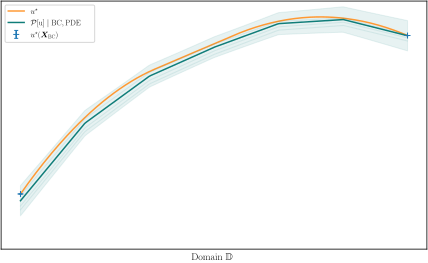

In [17]:
plot_belief(
    plt.gca(),
    u=u_cond_bc_pde,
    projection=trial_proj,
    conditioned_on=["bc", "pde"],
    Y_bc_meas=Y_bc,
    solution=bvp.solution,
)

experiment_utils.savefig("01_01_u_cond_bc_pde_proj")

## Solving the Noisy Problem

### Synthetic Measurements of the Boundary Values and Initial Conditions

In [18]:
meas_rng = np.random.default_rng(21489)

In [19]:
X_bc, Y_bc = linpde_gp.problems.pde.get_1d_dirichlet_boundary_observations(bvp.boundary_conditions)

In [20]:
noise_bc_meas = pn.randvars.Normal(
    mean=np.zeros_like(Y_bc),
    cov=0.1**2 * np.eye(Y_bc.size),
)

Y_bc_meas = Y_bc + noise_bc_meas.sample(meas_rng)

In [21]:
num_rhs_meas = 10

X_rhs = bvp.domain.uniform_grid(num_rhs_meas + 2)[1:-1]

noise_rhs_meas = pn.randvars.Normal(
    mean=np.zeros_like(X_rhs),
    cov=0.2 ** 2 * np.eye(X_rhs.size),
)

Y_rhs_meas = bvp.pde.rhs(X_rhs) + noise_rhs_meas.sample(meas_rng)

In [22]:
num_u_meas = 3

X_u_meas = bvp.domain.uniform_grid(num_u_meas + 2)[1:-1]

noise_u_meas = pn.randvars.Normal(
    mean=np.zeros_like(X_u_meas),
    cov=0.05 ** 2 * np.eye(num_u_meas),
)

Y_u_meas = bvp.solution(X_u_meas) + noise_u_meas.sample(meas_rng)

### RHS Belief

In [23]:
f_prior = pn.randprocs.GaussianProcess(
    mean=linpde_gp.functions.Constant(
        input_shape=(),
        value=1.5,
    ),
    cov=pn.randprocs.kernels.Matern(
        input_shape=(),
        lengthscales=0.5,
        nu=0.5,
    )
)

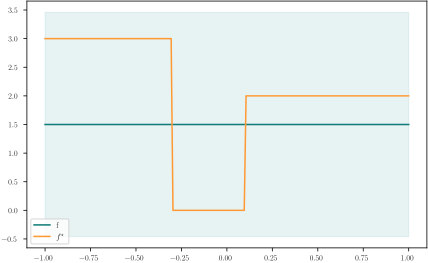

In [24]:
f_prior.plot(
    plt.gca(),
    plt_grid,
    label="f",
)

bvp.pde.rhs.plot(
    plt.gca(),
    plt_grid,
    label="$f^\star$"
)

plt.legend()
plt.show()

In [25]:
f_cond_meas = f_prior.condition_on_observations(
    Y_rhs_meas,
    X=X_rhs,
    b=noise_rhs_meas,
)

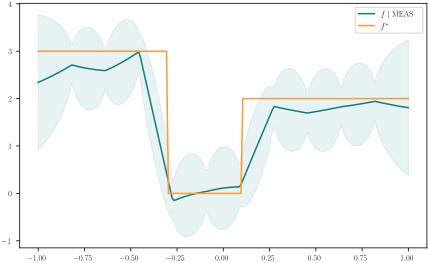

In [26]:
f_cond_meas.plot(
    plt.gca(),
    plt_grid,
    label=r"$f \mid \text{MEAS}$",
)

bvp.pde.rhs.plot(
    plt.gca(),
    plt_grid,
    label="$f^\star$"
)

plt.legend()
plt.show()

### Conditioning on the Measured Boundary Conditions

In [27]:
u_cond_bc = u_prior.condition_on_observations(
    Y_bc_meas,
    X=X_bc,
    b=noise_bc_meas,
)

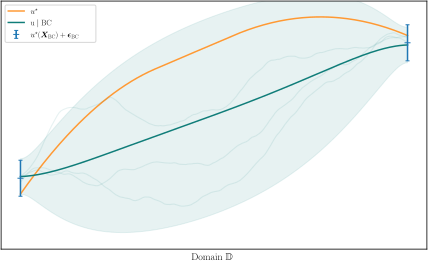

In [28]:
plot_belief(
    plt.gca(),
    u=u_cond_bc,
    conditioned_on=["bc"],
    Y_bc_meas=Y_bc_meas,
    noise_bc_meas=noise_bc_meas,
    solution=bvp.solution,
)

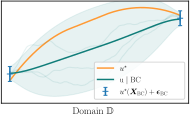

In [29]:
with plt.rc_context(
    config.tueplots_bundle(
        rel_width=fig_1_plot_rel_width,
        height_to_width_ratio=fig_1_plot_aspect,
    )
):
    plot_belief(
        plt.gca(),
        u=u_cond_bc,
        conditioned_on=["bc"],
        Y_bc_meas=Y_bc_meas,
        noise_bc_meas=noise_bc_meas,
        solution=bvp.solution,
    )

    experiment_utils.savefig("02_00_u_cond_bc_fig_1")

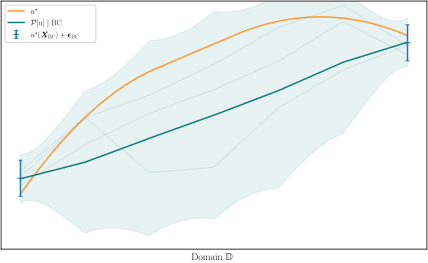

In [30]:
plot_belief(
    plt.gca(),
    u=u_cond_bc,
    projection=trial_proj,
    conditioned_on=["bc"],
    Y_bc_meas=Y_bc_meas,
    noise_bc_meas=noise_bc_meas,
    solution=bvp.solution,
)

# experiment_utils.savefig("02_00_u_cond_bc_proj")

### Conditioning on the PDE with Uncertain RHS

In [31]:
diffop_galerkin = bvp.pde.diffop.weak_form(test_basis)(trial_basis)
rhs_galerkin = test_proj(f_cond_meas)

In [32]:
u_cond_bc_pde = u_cond_bc.condition_on_observations(
    np.zeros_like(rhs_galerkin.mean),
    L=diffop_galerkin @ trial_proj,
    b=-rhs_galerkin,
)

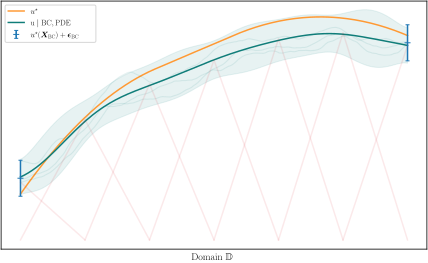

In [33]:
plot_belief(
    plt.gca(),
    u=u_cond_bc_pde,
    conditioned_on=["bc", "pde"],
    Y_bc_meas=Y_bc_meas,
    noise_bc_meas=noise_bc_meas,
    show_projection_basis=trial_proj,
    solution=bvp.solution,
)

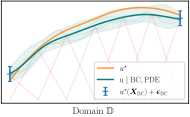

In [34]:
with plt.rc_context(
    config.tueplots_bundle(
        rel_width=fig_1_plot_rel_width,
        height_to_width_ratio=fig_1_plot_aspect,
    )
):
    plot_belief(
        plt.gca(),
        u=u_cond_bc_pde,
        conditioned_on=["bc", "pde"],
        Y_bc_meas=Y_bc_meas,
        noise_bc_meas=noise_bc_meas,
        show_projection_basis=trial_proj,
        solution=bvp.solution,
    )

    experiment_utils.savefig("02_01_u_cond_bc_pde_fig_1")

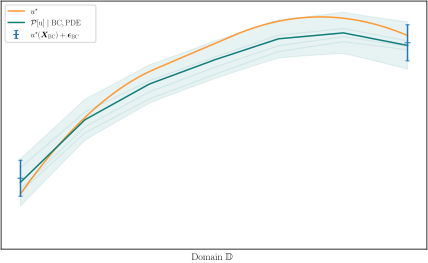

In [35]:
plot_belief(
    plt.gca(),
    u=u_cond_bc_pde,
    projection=trial_proj,
    conditioned_on=["bc", "pde"],
    Y_bc_meas=Y_bc_meas,
    noise_bc_meas=noise_bc_meas,
    solution=bvp.solution,
)

# experiment_utils.savefig("02_01_u_cond_bc_pde_proj")

### Conditioning on Measurements of the Solution

In [36]:
u_cond_bc_pde_meas = u_cond_bc_pde.condition_on_observations(
    Y_u_meas,
    X=X_u_meas,
    b=noise_u_meas,
)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ((Sqrt(((a-b)*c)**2)+d)*e)*Exp(-Sqrt(((a-b)*c)**2)) with a=Var(0,1,0), b=Var(1,1,1), c=Var(2,1,2), d=Var(3,1,2), e=Var(4,1,1) ... OK
[pyKeOps] Compiling pykeops cpp 0e17c4c69c module ... OK
[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula ((Sqrt(((a-b)*c)**2)+d)*e)*Exp(-Sqrt(((a-b)*c)**2)) with a=Var(0,1,1), b=Var(1,1,0), c=Var(2,1,2), d=Var(3,1,2), e=Var(4,1,1) ... OK
[pyKeOps] Compiling pykeops cpp c582165d1b module ... OK


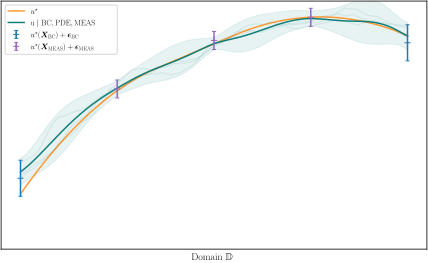

In [37]:
plot_belief(
    plt.gca(),
    u=u_cond_bc_pde_meas,
    conditioned_on=["bc", "pde", "u_meas"],
    Y_bc_meas=Y_bc_meas,
    noise_bc_meas=noise_bc_meas,
    X_u_meas=X_u_meas,
    Y_u_meas=Y_u_meas,
    noise_u_meas=noise_u_meas,
    solution=bvp.solution,
)

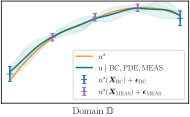

In [38]:
with plt.rc_context(
    config.tueplots_bundle(
        rel_width=fig_1_plot_rel_width,
        height_to_width_ratio=fig_1_plot_aspect,
    )
):
    plot_belief(
        plt.gca(),
        u=u_cond_bc_pde_meas,
        conditioned_on=["bc", "pde", "u_meas"],
        Y_bc_meas=Y_bc_meas,
        noise_bc_meas=noise_bc_meas,
        X_u_meas=X_u_meas,
        Y_u_meas=Y_u_meas,
        noise_u_meas=noise_u_meas,
        solution=bvp.solution,
    )

    experiment_utils.savefig("02_02_u_cond_bc_pde_meas_fig_1")

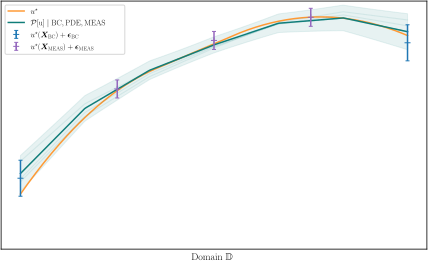

In [39]:
plot_belief(
    plt.gca(),
    u=u_cond_bc_pde_meas,
    projection=trial_proj,
    conditioned_on=["bc", "pde", "u_meas"],
    Y_bc_meas=Y_bc_meas,
    noise_bc_meas=noise_bc_meas,
    X_u_meas=X_u_meas,
    Y_u_meas=Y_u_meas,
    noise_u_meas=noise_u_meas,
    solution=bvp.solution,
)

# experiment_utils.savefig("02_02_u_cond_bc_pde_meas_proj")

### Stacked Uncertainty Plot

In [40]:
std_prior = u_prior.std(plt_grid)
std_cond_bc = u_cond_bc.std(plt_grid)
std_cond_bc_pde = u_cond_bc_pde.std(plt_grid)
std_cond_bc_pde_u_meas = u_cond_bc_pde_meas.std(plt_grid)

In [41]:
# from https://stackoverflow.com/questions/31908982/python-matplotlib-multi-color-legend-entry/67870930#67870930
from matplotlib.collections import PatchCollection, PolyCollection

class MulticolorPatch:
    def __init__(self, fill_polys: list[PolyCollection]):
        self.colors = [tuple(fill_poly.get_facecolor()[0]) for fill_poly in fill_polys]
        self.alphas = [fill_poly.get_alpha() for fill_poly in fill_polys]

class MulticolorPatchHandler:
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, (c, a) in enumerate(zip(orig_handle.colors, orig_handle.alphas)):
            patches.append(
                plt.Rectangle(
                    [
                        width / len(orig_handle.colors) * i - handlebox.xdescent,
                        -handlebox.ydescent,
                    ],
                    width / len(orig_handle.colors),
                    height,
                    facecolor=c,
                    edgecolor=c,
                    alpha=a,
                )
            )

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

In [ ]:
with plt.rc_context(
    config.tueplots_bundle(
        rel_width=0.45,
        # height_to_width_ratio=fig_1_plot_aspect,
    )
):
    fill_polys = []

    fill_polys.append(
        plt.fill_between(
            plt_grid,
            std_prior,
            std_cond_bc,
            color=config.color["bc"],
            alpha=0.85,
            label=r"$\mathrm{u} \sim \mathcal{GP}(m, k)$",
        )
    )

    fill_polys.append(
        plt.fill_between(
            plt_grid,
            std_cond_bc,
            std_cond_bc_pde,
            color=config.color["pde"],
            alpha=0.85,
            label=r"$\mathrm{u} \mid \mathrm{BC}$",
        )
    )

    fill_polys.append(
        plt.fill_between(
            plt_grid,
            std_cond_bc_pde,
            std_cond_bc_pde_u_meas,
            color=config.color["u_meas"],
            alpha=0.85,
            label=r"$\mathrm{u} \mid \dots, \mathrm{PDE}$",
        )
    )

    fill_polys.append(
        plt.fill_between(
            plt_grid,
            std_cond_bc_pde_u_meas,
            color=config.color["u"],
            alpha=0.85,
            label=r"$\mathrm{u} \mid \dots, \mathrm{MEAS}$",
        )
    )

    plt.autoscale(enable=True, axis="both", tight=True)

    plt.gca().set(
        xlabel=r"Domain $\mathbb{D}$",
        ylabel="Marginal Std. Dev.",
        xticks=[],
        yticks=[],
    )

    _, legend_labels = plt.gca().get_legend_handles_labels()

    plt.legend(
        [MulticolorPatch(fill_polys[idx:]) for idx in range(4)],
        legend_labels,
        handler_map={MulticolorPatch: MulticolorPatchHandler()},
    )

    experiment_utils.savefig("02_03_stacked_uncertainty_fig_1")